In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.path as mpath
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis as cfv
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator, CubicSpline, interp1d, PchipInterpolator, RegularGridInterpolator
from scipy.spatial import Delaunay
from scipy.ndimage import gaussian_filter
import sys
import os
import json
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape, Concatenate
from tensorflow.keras.models import Model
from tqdm import tqdm

In [2]:
def read_am_file(file_path,slices=None,sigma=0):    
    # Search for the binary data section marker "@1"
    marker = b"@1"
    with open(file_path, 'rb') as file:
        content = file.read()
        start = content.find(marker) + len(marker)
        
        # Assuming there are two newline characters after the "@1" marker
        # Adjust if necessary based on the actual file format
        start += 32
        
        # The total number of data points is the product of the lattice dimensions
        # Each point has 2 float components
        num_points = 512 * 512 * 1001 * 2
        
        # Set the file pointer to the start of the binary data and read it
        file.seek(start)
        data = np.fromfile(file, dtype=np.float32)
        
        # Reshape the data to the correct dimensions (512, 512, 1001, 2)
        # The last dimension is 2 for the two components of velocity at each grid point
        data = data.reshape((1001,512, 512, 2))

        if sigma != 0:
            data = gaussian_filter(data, sigma=(0, sigma, sigma, 0), mode='wrap')
        data = data*(1/data.std())
        # return data[:,200:400,200:400,:]
        # return data[:,:250,:250,100:800]
        if slices:
            data = data[slices[0],slices[1],slices[2],:]
            print(data.shape)
        return data
    
class IsInDomain:
    def __init__(self, nodesCurves):
        self.loops = [mpath.Path(nodesCurves[i]) for i in range(len(nodesCurves))]
        
    def __call__(self, points):
        return np.logical_and(self.loops[0].contains_points(points),np.logical_not(np.array([loop.contains_points(points) for loop in self.loops[1:]]).any(0)))
    
class Interp2dAcrossTimesteps:
    def __init__(self, data, x_coords, y_coords, kind='linear'):
        # self.data = data
        # self.x_coords = x_coords
        # self.y_coords = y_coords
        self.interp = [RegularGridInterpolator((x_coords,y_coords),  np.transpose(data[i,:,:,:],(1,0,2)), method=kind, bounds_error=False, fill_value=None) for i in range(data.shape[0])]

    def __call__(self, points, timesteps):
        return np.concatenate([self.interp[timestep](points) for timestep in timesteps],-1)
    
    def stack(self, points, timesteps):
        return np.stack([self.interp[timestep](points) for timestep in timesteps],0)
    
    
class Interp2Dslice:
    def __init__(self, interp2dAT, dT_arr):
        self.interp2dAT = interp2dAT
        self.dT_arr = dT_arr
        self.nDims = len(dT_arr)*2
    
    def __call__(self, points):
        return self.interp2dAT(points, self.dT_arr)
        
    
class Interp1DPeriodic:
    def __init__(self, x, y, kind = 'linear'):
        self.x = x
        self.y = y
        self.kind = kind
        self.spline = interp1d(self.x,self.y,kind=self.kind,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])
    
class Interp1DPchipPeriodic:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.spline = PchipInterpolator(self.x,self.y,axis=0)
    
    def __call__(self, x):
        return self.spline(x%self.x[-1])

class Interp1dAcrossTimesteps:
    def __init__(self, dataB, distance, kind='pchip'):
        self.nDims = dataB.shape[-1]
        if kind == 'pchip':
            self.interp = [Interp1DPchipPeriodic(distance, dataB[i]) for i in range(dataB.shape[0])]
        else:
            self.interp = [Interp1DPeriodic(distance, dataB[i],kind=kind) for i in range(dataB.shape[0])]

    def __call__(self, x, timesteps):
        # return np.stack([self.interp[timestep](x) for timestep in timesteps],0)
        return np.concatenate([self.interp[timestep](x) for timestep in timesteps],-1)
    
class Interp1Dslice:
    def __init__(self, interp1dAT, dT_arr):
        self.interp1dAT = interp1dAT
        self.dT_arr = dT_arr
        self.nDims = len(dT_arr)*interp1dAT.nDims
    
    def __call__(self, x):
        return self.interp1dAT(x, self.dT_arr)

# input: file_path,dT_arr
def loadData(file_path, dT_arr, gradsBC = False, slices=None, sigma=0):
    data = read_am_file(file_path,slices=slices,sigma=sigma)

    NT = data.shape[0]
    NX = data.shape[1]
    NY = data.shape[2]
    Nv = data.shape[3]

    x = np.linspace(0, 1, NX)
    X,Y = np.meshgrid(x, x)

    # Comon for all timesteps
    nodes = np.stack([X.flatten(),Y.flatten()],-1)
    idxCorner = np.array([0,NX-1,NX*(NY-1),NX*NY-1],dtype=int)
    elementsBoundaryNodesOnly = np.array([[idxCorner[0],idxCorner[2],idxCorner[1]],[idxCorner[2],idxCorner[3],idxCorner[1]]],dtype=int)
    areaElementsBoundaryNodesOnly = np.array([0.5,0.5])
    isInDomain = IsInDomain([nodes[[idxCorner[0],idxCorner[1],idxCorner[3],idxCorner[2],idxCorner[0]]]])
    idxCurves = [np.concatenate([np.arange(NX),np.arange(2*NX-1,NY*NX,NX),np.arange(NY*NX-2,(NY-1)*NX-1,-1),np.arange((NY-2)*NX,-1,-NX)])]
    distance = [np.arange(0,idxCurve.shape[0])*1.0/(NX-1) for idxCurve in idxCurves]
    lengthCurves = [4]
    nodesCurves = [nodes[idxCurve] for idxCurve in idxCurves]
    idxCurveCorner = np.array([0,0,0,0],dtype=int)
    distanceCornerCurve = np.array([0,1,3,2],dtype=int)
    distance2boundary = np.min(np.stack([np.abs(X),np.abs(X-1),np.abs(Y),np.abs(Y-1)],-1),-1)
    interpD2B = RegularGridInterpolator((x,x),distance2boundary, method='linear', bounds_error=False, fill_value=None)
    interpBC = [Interp1DPeriodic(distance[0],nodesCurves[0],kind='linear')]
    normalCurves = [np.zeros((idxCurves[0].shape[0],2))]
    normalCurves[0][nodesCurves[0][:,0]==0,0] = -1
    normalCurves[0][nodesCurves[0][:,0]==1,0] = 1
    normalCurves[0][nodesCurves[0][:,1]==0,1] = -1
    normalCurves[0][nodesCurves[0][:,1]==1,1] = 1
    normalCurves[0] = normalCurves[0]/np.sqrt(np.sum(normalCurves[0]**2,1,keepdims=True))
    interpBN = [Interp1DPeriodic(distance[0],normalCurves[0],kind='linear')]
    # idxCorner = [0,511,512*512-1,512*511]
    idxCorner = [0,NX-1,NX*NY-1,NX*(NY-1)]

    interp2dAcrossTimesteps = Interp2dAcrossTimesteps(data, x, x)
    dataB = [data.reshape((NT,NX*NY,Nv))[:,idxCurves[0],:]]
    if gradsBC:
        nodesB = [nodes[idxCurves[0]]]
        nodesB_offset = [nodesB[0]-normalCurves[0]*1.0/(NX-1)]
        dataB_offset = [interp2dAcrossTimesteps.stack(nodesB_offset[0], np.arange(NT))]
        dataB_dn = [(dataB[0]-dataB_offset[0])*(NX-1)*0.7]
        dataB = [np.concatenate([dataB_dn[0],dataB[0]],-1)]
        
    interp1dAcrossTimesteps = [Interp1dAcrossTimesteps(dataB[0], distance[0], kind='pchip')]

    data_processed = []
    for i in range(-dT_arr[0],NT-dT_arr[-1]):
        # interpSE = lambda points, idxs = dT_arr+i: interp2dAcrossTimesteps(points, idxs)
        # interpSD = lambda points, idxs = [i]: interp2dAcrossTimesteps(points, idxs)
        interpSE = Interp2Dslice(interp2dAcrossTimesteps, dT_arr+i)
        interpSD = Interp2Dslice(interp2dAcrossTimesteps, [i])
        # interpBS = [lambda x,idxs=dT_arr+i: interp1dAcrossTimesteps[0](x, idxs)]
        interpBS = [Interp1Dslice(interp1dAcrossTimesteps[0], dT_arr+i)]
        data_processed.append(
            {'nodes': nodes,'elementsBoundaryNodesOnly': elementsBoundaryNodesOnly,'areaElementsBoundaryNodesOnly': areaElementsBoundaryNodesOnly,
            'isInDomainF': isInDomain,'interpSE': interpSE,'interpSD': interpSD,'interpD2B': interpD2B,'nodesCurves': nodesCurves,
            'lengthCurves': lengthCurves,'interpBC': interpBC,'interpBS': interpBS,'interpBN': interpBN,
            'distaceCornerCurve': distanceCornerCurve, 'idxCurveCorner': idxCurveCorner, 'idxCorner': idxCorner, 'dT': i, 'idxCurves': idxCurves,
            'distance': distance}
        )

    return data_processed

In [3]:
def unet(input_shape=(32, 32, 2),layer_sizes=(32,64,128)):
    inputs = layers.Input(shape=input_shape)

    # Encoder path
    # Level 1
    c1 = layers.Conv2D(layer_sizes[0], (3,3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2,2))(c1) # 16x16

    # Level 2
    c2 = layers.Conv2D(layer_sizes[1], (3,3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2,2))(c2) # 8x8

    # Level 3 (Bottleneck)
    c3 = layers.Conv2D(layer_sizes[2], (3,3), activation='relu', padding='same')(p2)

    # Decoder path
    # Level 2 up
    u2 = layers.UpSampling2D((2,2))(c3) # 16x16
    u2 = layers.concatenate([u2, c2], axis=-1)
    c4 = layers.Conv2D(layer_sizes[1], (3,3), activation='relu', padding='same')(u2)

    # Level 1 up
    u1 = layers.UpSampling2D((2,2))(c4) # 32x32
    u1 = layers.concatenate([u1, c1], axis=-1)
    c5 = layers.Conv2D(layer_sizes[0], (3,3), activation='relu', padding='same')(u1)

    # Output layer
    # We want output shape (32,32,2), so number of filters = 2
    # Choose activation according to your task (e.g., 'sigmoid', 'softmax', or 'linear')
    outputs = layers.Conv2D(2, (1,1), activation=None)(c5)

    model = Model(inputs, outputs, name='unet_from_scratch')
    return model

In [4]:
def unet2(input_shape=(32, 32, 2),layer_sizes=(32,64,128)):
    inputs = layers.Input(shape=input_shape)

    # Encoder path
    # Level 1
    c1 = layers.Conv2D(layer_sizes[0], (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(layer_sizes[0], (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1) # 16x16

    # Level 2
    c2 = layers.Conv2D(layer_sizes[1], (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(layer_sizes[1], (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2) # 8x8

    # Level 3 (Bottleneck)
    c3 = layers.Conv2D(layer_sizes[2], (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(layer_sizes[2], (3,3), activation='relu', padding='same')(c3)

    # Decoder path
    # Level 2 up
    u2 = layers.UpSampling2D((2,2))(c3) # 16x16
    u2 = layers.concatenate([u2, c2], axis=-1)
    c4 = layers.Conv2D(layer_sizes[1], (3,3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(layer_sizes[1], (3,3), activation='relu', padding='same')(c4)

    # Level 1 up
    u1 = layers.UpSampling2D((2,2))(c4) # 32x32
    u1 = layers.concatenate([u1, c1], axis=-1)
    c5 = layers.Conv2D(layer_sizes[0], (3,3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(layer_sizes[0], (3,3), activation='relu', padding='same')(c5)

    # Output layer
    # We want output shape (32,32,2), so number of filters = 2
    # Choose activation according to your task (e.g., 'sigmoid', 'softmax', or 'linear')
    outputs = layers.Conv2D(2, (1,1), activation=None)(c5)

    model = Model(inputs, outputs, name='unet_from_scratch')
    return model

In [5]:
file_path = r'TrainingData/TurbulentFlowData/4000.am'
sigma = 20
d = read_am_file(file_path,sigma=sigma)
# encoder_data_history_range = (-30,10+1,10)
encoder_data_history_range = (-40,0+1,10)
file_path = r'TrainingData/TurbulentFlowData/4000.am'
slices = [slice(0,1001,1),slice(0,250,1),slice(250,500,1)]
data = loadData(file_path, np.arange(*encoder_data_history_range), gradsBC=True, slices=slices, sigma=sigma)
data_train = data
slices_test = [slice(0,1001,1),slice(250,500,1),slice(250,500,1)]
data_test = loadData(file_path, np.arange(*encoder_data_history_range), gradsBC=True, slices=slices_test, sigma=sigma)

(1001, 250, 250, 2)
(1001, 250, 250, 2)


In [6]:
def GetX(data,n_grid = 16):
    x = np.linspace(0,1,n_grid)
    X,Y = np.meshgrid(x,x)

    nodesB = data['nodesCurves'][0]
    distance = data['distance']
    bcVals = data['interpBS'][0](distance)[0]
    normalVals = data['interpBN'][0](distance)[0]
    bcVals = np.concatenate([bcVals,normalVals],-1)
    interpBC = LinearNDInterpolator(nodesB,bcVals)
    vals_interp = interpBC(np.stack([X.flatten(),Y.flatten()],-1)).reshape((n_grid,n_grid,-1))
    return vals_interp

In [7]:
n_grid = 16
x = np.linspace(0,1,n_grid)
X,Y = np.meshgrid(x,x)
nodes = np.stack([X,Y],-1)

alpha = np.arctan2(Y-0.5,X-0.5)+(3*np.pi/4)
alpha[alpha<0]+=2*np.pi
distance = alpha*4/2/np.pi

n_skip = 30
n_max = 0
# X_train = np.stack([data_train[i]['interpBS'][0](distance) for i in range(0,len(data)-n_max,n_skip)],axis=0)
X_train = np.stack([GetX(data_train[i]) for i in range(0,len(data)-n_max,n_skip)],axis=0)
Y_train = np.stack([data_train[i]['interpSD'](nodes) for i in range(0,len(data)-n_max,n_skip)],axis=0)
x_mean,x_std = X_train.mean((0,1,2),keepdims=True), X_train.std((0,1,2),keepdims=True)
y_mean,y_std = Y_train.mean((0,1,2),keepdims=True), Y_train.std((0,1,2),keepdims=True)
X_train = (X_train-x_mean)/x_std
Y_train = (Y_train-y_mean)/y_std

# X_test = np.stack([data_test[i]['interpBS'][0](distance) for i in range(0,len(data),100)],axis=0)
X_test = np.stack([GetX(data_test[i]) for i in range(0,len(data),100)],axis=0)
Y_test = np.stack([data_test[i]['interpSD'](nodes) for i in range(0,len(data),100)],axis=0)
X_test = (X_test-x_mean)/x_std
Y_test = (Y_test-y_mean)/y_std

In [18]:
layer_sizes = np.array((1,2,4))*128
model = unet(input_shape=X_train.shape[1:], layer_sizes=layer_sizes)
# model.summary()
# Compile the model with an appropriate optimizer and loss function for regression
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
    loss='mse',             # Mean Squared Error for regression
    metrics=['mae']         # Mean Absolute Error as an additional metric
)

# Train the model
history = model.fit(
    X_train, Y_train,
    batch_size=32,          # Adjust batch size as needed
    epochs=300,             # Adjust the number of epochs based on your needs
    validation_data=(X_test, Y_test),
    shuffle=True,
    verbose=1               # Set to 1 or 2 for more/less verbose output
)

Epoch 1/300
2/2 [==============================] - 0s 96ms/step - loss: 1.0606 - mae: 0.8274 - val_loss: 17.4178 - val_mae: 3.1785
Epoch 2/300
2/2 [==============================] - 0s 41ms/step - loss: 14.4943 - mae: 2.8512 - val_loss: 0.4494 - val_mae: 0.5406
Epoch 3/300
2/2 [==============================] - 0s 45ms/step - loss: 0.4248 - mae: 0.5302 - val_loss: 0.5256 - val_mae: 0.5712
Epoch 4/300
2/2 [==============================] - 0s 40ms/step - loss: 0.5691 - mae: 0.6131 - val_loss: 0.4568 - val_mae: 0.5211
Epoch 5/300
2/2 [==============================] - 0s 41ms/step - loss: 0.5055 - mae: 0.5732 - val_loss: 0.3267 - val_mae: 0.4300
Epoch 6/300
2/2 [==============================] - 0s 40ms/step - loss: 0.3445 - mae: 0.4668 - val_loss: 0.2712 - val_mae: 0.3994
Epoch 7/300
2/2 [==============================] - 0s 39ms/step - loss: 0.2302 - mae: 0.3769 - val_loss: 0.3227 - val_mae: 0.4519
Epoch 8/300
2/2 [==============================] - 0s 39ms/step - loss: 0.2017 - mae: 0.

0.16650176048278809


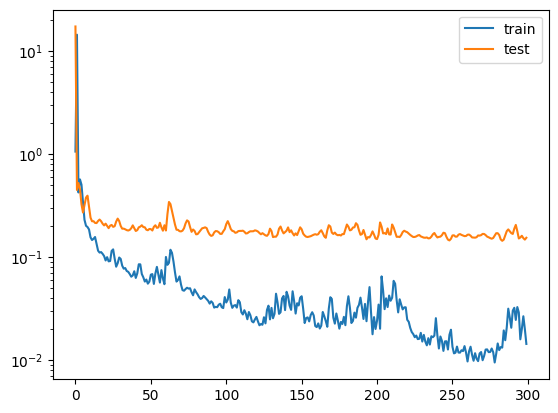

In [19]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.gca().set_yscale('log')
print(np.mean(history.history['val_loss'][-10:]))

In [26]:
# X_test = np.stack([data_test[i]['interpBS'][0](distance) for i in range(0,len(data),5)],axis=0)
X_test = np.stack([GetX(data_test[i]) for i in range(0,len(data),5)],axis=0)
Y_test = np.stack([data_test[i]['interpSD'](nodes) for i in range(0,len(data),5)],axis=0)

X_test = (X_test-x_mean)/x_std
Y_test = (Y_test-y_mean)/y_std
Y_test_pred = model(X_test)

In [29]:
np.save('tmp/Y_test.npy',Y_test)
np.save('tmp/Y_test_pred.npy',Y_test_pred)

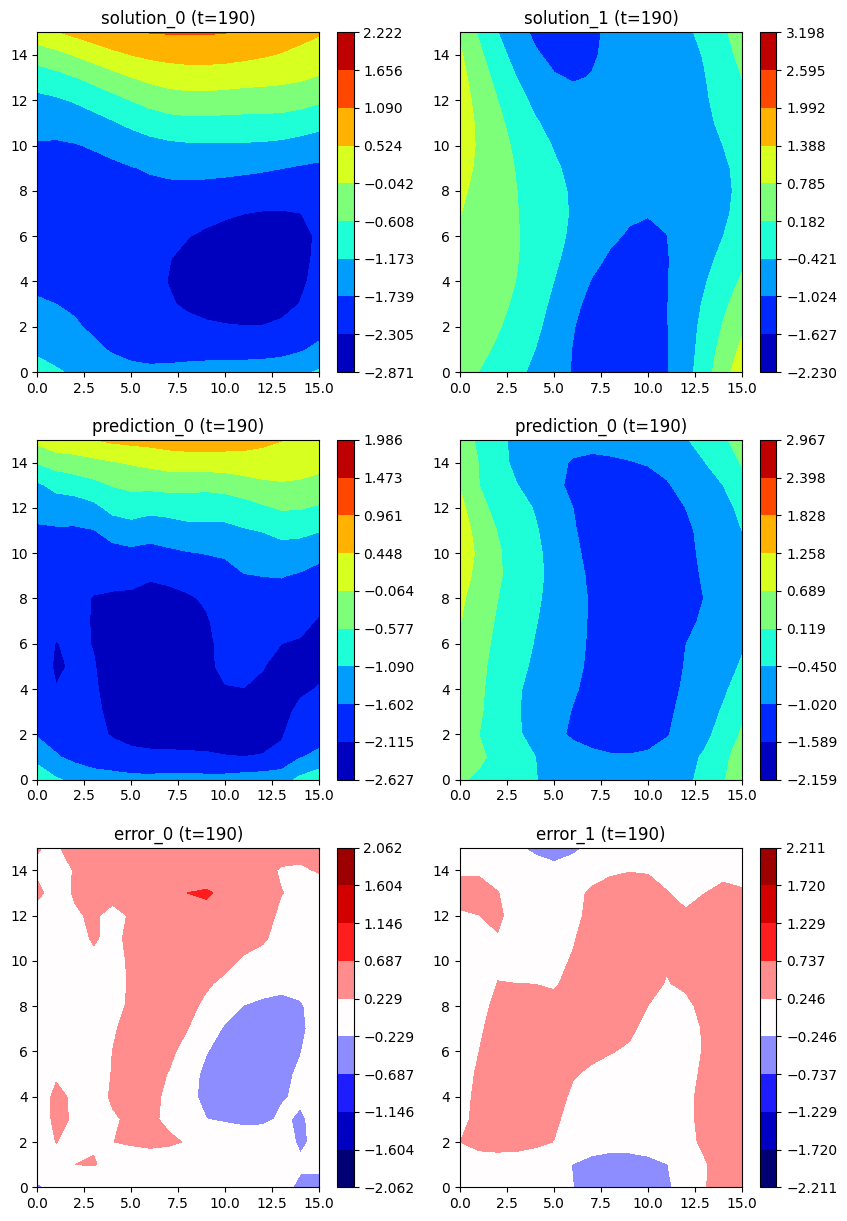

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.animation as animation

def AnimatePredDynamicData(y,y_pred, filename, colormap = 'jet', n_levels=10):
    if isinstance(colormap, str):
        colormap = [colormap]*3

    err = y-y_pred
    n_rows = 3
    n_cols = 2
    fig, axs = plt.subplots(n_rows,n_cols, figsize=(10, 15))

    y_lims = [y.min((0,1,2)),y.max((0,1,2))]
    y_levels = [np.linspace(y_lims[0][0],y_lims[1][0],n_levels),np.linspace(y_lims[0][1],y_lims[1][1],n_levels)]
    cont = axs[0,0].contourf(y[0,...,0],cmap=colormap[0], levels=y_levels[0])
    axs[0,0].set_title(f"solution_0 (t={0})")
    fig.colorbar(cont, ax=axs[0,0])
    cont = axs[0,1].contourf(y[0,...,1],cmap=colormap[0], levels=y_levels[1])
    axs[0,1].set_title(f"solution_1 (t={0})")
    fig.colorbar(cont, ax=axs[0,1])

    y_pred_lims = [y_pred.min((0,1,2)),y_pred.max((0,1,2))]
    y_pred_levels = [np.linspace(y_pred_lims[0][0],y_pred_lims[1][0],n_levels),np.linspace(y_pred_lims[0][1],y_pred_lims[1][1],n_levels)]
    cont = axs[1,0].contourf(y_pred[0,...,0],cmap=colormap[1], levels=y_pred_levels[0])
    axs[1,0].set_title(f"prediction_0 (t={0})")
    fig.colorbar(cont, ax=axs[1,0])
    cont = axs[1,1].contourf(y_pred[0,...,1],cmap=colormap[1], levels=y_pred_levels[1])
    axs[1,1].set_title(f"prediction_0 (t={0})")
    fig.colorbar(cont, ax=axs[1,1])

    err_max = np.abs(err).max((0,1,2))
    levels_err = [np.linspace(-err_max[0],err_max[0],n_levels),np.linspace(-err_max[1],err_max[1],n_levels)]
    cont = axs[2,0].contourf(err[0,...,0],cmap=colormap[2], levels=levels_err[0])
    axs[2,0].set_title(f"error_0 (t={0})")
    fig.colorbar(cont, ax=axs[2,0])
    cont = axs[2,1].contourf(err[0,...,1],cmap=colormap[2], levels=levels_err[1])
    axs[2,1].set_title(f"error_1 (t={0})")
    fig.colorbar(cont, ax=axs[2,1])

    # animation function
    def animate(j):
        cont = axs[0,0].contourf(y[j,...,0],cmap=colormap[0], levels=y_levels[0])
        axs[0,0].set_title(f"solution_0 (t={j})")
        cont = axs[0,1].contourf(y[j,...,1],cmap=colormap[0], levels=y_levels[1])
        axs[0,1].set_title(f"solution_1 (t={j})")

        cont = axs[1,0].contourf(y_pred[j,...,0],cmap=colormap[1], levels=y_pred_levels[0])
        axs[1,0].set_title(f"prediction_0 (t={j})")
        cont = axs[1,1].contourf(y_pred[j,...,1],cmap=colormap[1], levels=y_pred_levels[1])
        axs[1,1].set_title(f"prediction_0 (t={j})")

        cont = axs[2,0].contourf(err[j,...,0],cmap=colormap[2], levels=levels_err[0])
        axs[2,0].set_title(f"error_0 (t={j})")
        cont = axs[2,1].contourf(err[j,...,1],cmap=colormap[2], levels=levels_err[1])
        axs[2,1].set_title(f"error_1 (t={j})")
        return None

    anim = animation.FuncAnimation(fig, animate, frames=y.shape[0]-2, interval=50, repeat=False)
    anim.save(f'{filename}.gif', writer='pillow')
    return anim

# Example Usage
anim = AnimatePredDynamicData(Y_test, Y_test_pred.numpy(),"gifs/DynamicData/predDynamicData4000_20_UNET", colormap=['jet','jet','seismic'], n_levels=10)
plt.show()

In [13]:
layer_size_base = np.array((1,2,4))
scalar_arr = 2**np.arange(1,10)

history_arr = []

for i,scalar in enumerate(scalar_arr[:]):
    print(f"scalar: {scalar} ({i+1}/{scalar_arr.shape[0]})")
    model = unet(input_shape=X_train.shape[1:], layer_sizes=layer_size_base*scalar)
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
        loss='mse',             # Mean Squared Error for regression
        metrics=['mae']         # Mean Absolute Error as an additional metric
    )

    history = model.fit(
        X_train, Y_train,
        batch_size=32,          # Adjust batch size as needed
        epochs=300,             # Adjust the number of epochs based on your needs
        validation_data=(X_test, Y_test),
        shuffle=True,
        verbose=0               # Set to 1 or 2 for more/less verbose output
    )
    history_arr.append(history)


scalar: 2 (1/9)
scalar: 4 (2/9)
scalar: 8 (3/9)
scalar: 16 (4/9)
scalar: 32 (5/9)
scalar: 64 (6/9)
scalar: 128 (7/9)
scalar: 256 (8/9)
scalar: 512 (9/9)


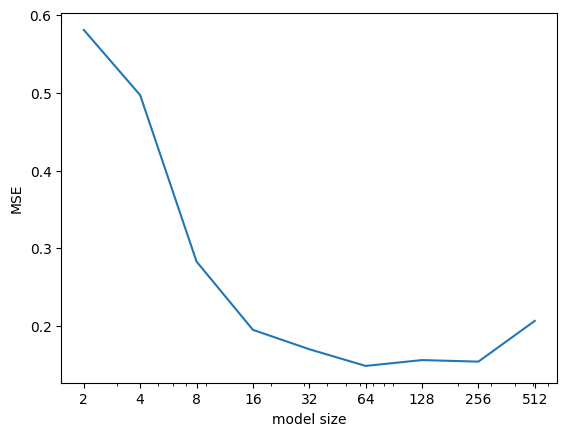

In [14]:
val_mse = []
for history in history_arr:
    val_mse.append(np.min(history.history['val_loss']))

plt.plot(scalar_arr,val_mse)
plt.xlabel("model size")
plt.ylabel("MSE")
plt.gca().set_xscale('log')
plt.xticks(scalar_arr, [str(scalar) for scalar in scalar_arr])
plt.show()

(0.12, 1.2)

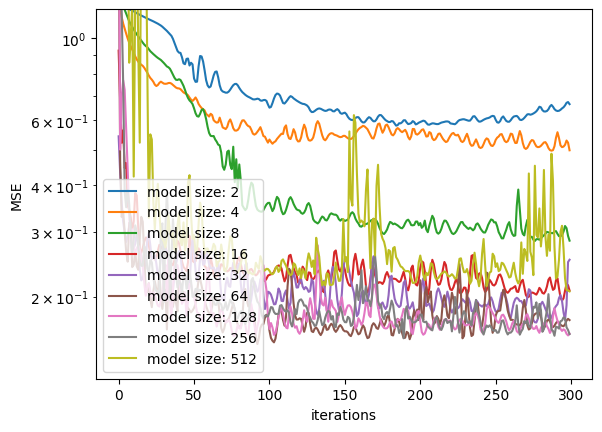

In [16]:
for i,history in enumerate(history_arr):
    plt.plot(history.history['val_loss'],label=f"model size: {scalar_arr[i]}")
# plt.plot([0,300],[0.027,0.027],'--',label='SINN result')
plt.gca().set_yscale('log')
plt.xlabel("iterations")
plt.ylabel("MSE")
plt.legend(loc='lower left')
plt.ylim([0.12,1.2])

In [ ]:
for i,history in enumerate(history_arr):
    plt.plot(history.history['val_loss'],label=f"model size: {scalar_arr[i]}")
plt.plot([0,300],[0.029,0.029],'--',label='SINN result')
plt.gca().set_yscale('log')
plt.xlabel("iterations")
plt.ylabel("MSE")
plt.legend(loc='lower left')
plt.ylim([0.027,1.2])